In [19]:
import pandas as pd
import numpy as np

# MATRIZ DE TRANSICIÓN DE ESTADOS PARA EL ENGAGEMENT

df = pd.read_csv("/Users/joshchaidez/Desktop/Globant_Motivation_Prediction/data/data_globant.csv")

# Discretizar el engagement
bins = np.arange(0, 5.25, 1)
labels = np.arange(1, 5.25, 1)

df["Engagement_bin"] = pd.cut(df["Engagement"], bins=bins, labels=labels, include_lowest=True)

df = df.sort_values(by=["Name", "Month", "Day"])

transition_counts = pd.DataFrame(
    0,
    index=labels,
    columns=labels,
    dtype=int
)

for name, group in df.groupby("Name"):
    states = group["Engagement_bin"].dropna().astype(float).values
    
    for (s1, s2) in zip(states[:-1], states[1:]):
        transition_counts.loc[s1, s2] += 1

transition_prob = transition_counts.div(transition_counts.sum(axis=1).replace(0, np.nan), axis=0)

# Eliminar probabilidades menores a un umbral en la matriz de probabilidades y normalizar
threshold = 0.05
transition_prob = transition_prob.where(transition_prob >= threshold, 0)

# Normalizar nuevamente
transition_prob = transition_prob.div(transition_prob.sum(axis=1).replace(0, np.nan), axis=0)

transition_counts, transition_prob

(     1.0  2.0   3.0   4.0   5.0
 1.0  262   33   200   131    28
 2.0   34  314   125    19     5
 3.0  190  137  2949   927    30
 4.0  146   15   951  2999   340
 5.0   32    5    23   359  1018,
           1.0       2.0       3.0       4.0       5.0
 1.0  0.418530  0.052716  0.319489  0.209265  0.000000
 2.0  0.071882  0.663848  0.264271  0.000000  0.000000
 3.0  0.000000  0.000000  0.760836  0.239164  0.000000
 4.0  0.000000  0.000000  0.221678  0.699068  0.079254
 5.0  0.000000  0.000000  0.000000  0.260712  0.739288)

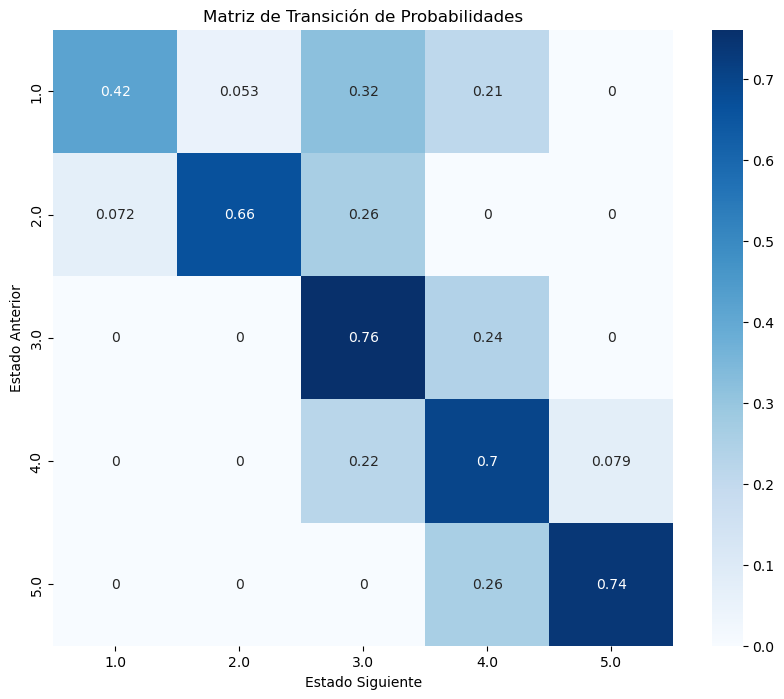

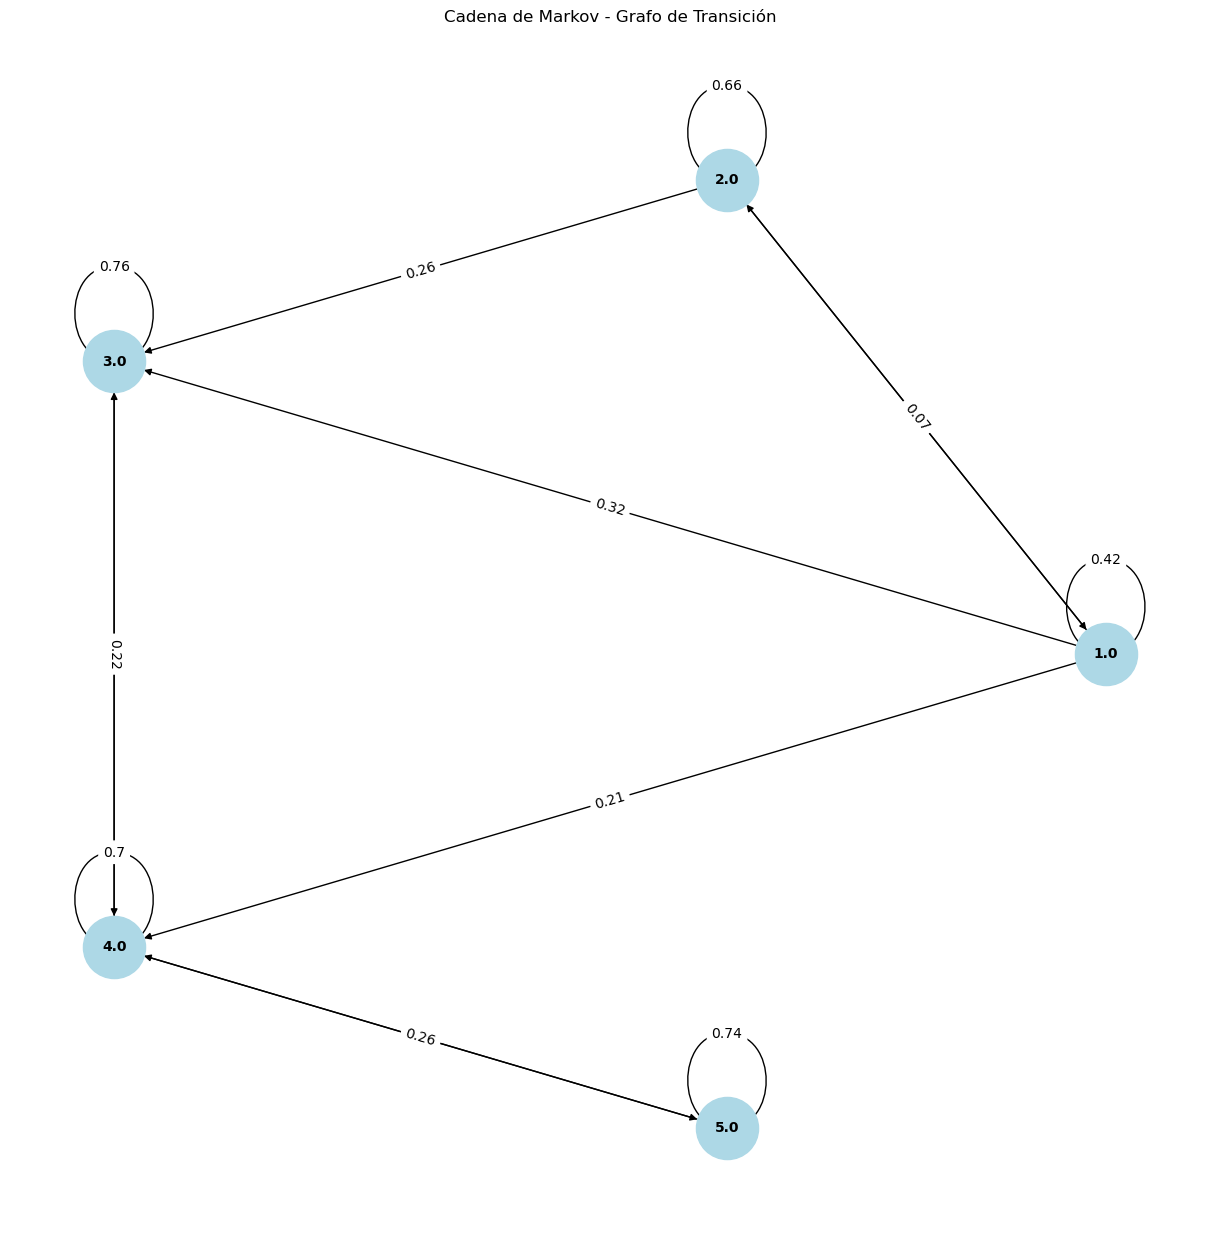

In [20]:
# Dibujar la matriz de transición de probabilidades
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(transition_prob, annot=True, cmap="Blues", cbar=True)
plt.title("Matriz de Transición de Probabilidades")
plt.xlabel("Estado Siguiente")
plt.ylabel("Estado Anterior")
plt.show()

# Dibujar la cadena de Markov como un grafo usando networkx redondeando probabilidades a 2 decimales colocando los nodos en circulo en orden ascendente respecto a el valor del estado
import networkx as nx

G = nx.DiGraph()

# Añadir nodos y aristas
for i in transition_prob.index:
    for j in transition_prob.columns:
        if transition_prob.loc[i, j] > 0:
            G.add_edge(i, j, weight=round(transition_prob.loc[i, j], 2))

# Dibujar el grafo
plt.figure(figsize=(12, 12))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightblue", font_size=10, font_weight="bold", arrows=True)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Cadena de Markov - Grafo de Transición")
plt.show()
